# $Introduction$
<hr style="height:5px; background-color:black;">

<span style="font-size: 20px;">$Scenario$</span>

I am a junior data analyst working with the marketing team at Bellabeat, a company aiming to become a larger player in the smart device market for women's health. Bellabeat has a line of products including Leaf (jewelry tracking activity, sleep, and stress), Time (a wellness watch), and Spring (a smart water bottle). My task is to analyse smart device data to understand how consumers use these products. My findings and subsequent high-level marketing recommendations will be presented to the Bellabeat executive team to help guide the company's growth strategy.

<span style="font-size: 20px;">$Product$ $Focus$</span>

For this case study, I have specifically chosen to concentrate on Bellabeat's Time product, a wellness watch with smart technology to track user activity, sleep, and stress. The Time watch connects to the Bellabeat app to provide insights on daily wellness. I believe the publicly available FitBit data, which focuses on these core metrics, can provide the most relevant insights for marketing the Time watch.

<span style="font-size: 20px;">$Case$ $Study$ $Objective$</span>

In this specific case study, I will analyse publicly available usage data from FitBit smart devices. The goal is to discover significant trends and patterns in activity, sleep, and wellness tracking that the Bellabeat marketing team can strategically utilise to drive growth for the Time product.

<span style="font-size: 20px;">$Limitation$</span>

The analysis data (Fitbit dataset) utilises a sample size consisting of only 33~35 unique users over a two-months period. Consequently, I cannot confirm whether this sample is sufficiently representative of the entire target population. This limitation affects the generalisability of the findings and necessitates caution when extrapolating results to a broader demographic.

<span style="color:red; font-size: 20px;">$Note$</span>

The files did not have metadata. The link is on their website: **[Fitabase | Resources | Knowledge Base](https://www.fitabase.com/resources/knowledge-base/exporting-data/data-dictionaries/)**

**Instructions: Click on the first `.pdf form here` to get the pdf that has all the metadata info**

# **Step 1:** $Ask$
<hr style="height:5px; background-color:black;">

$1$. *What are the top three most distinct user segments that emerge when clustering the $\textit{30} \sim \textit{35}$ users based on their average daily proportion of <u>Sedentary Minutes</u> versus <u>Very Active Minutes</u>?*

$2$. *Is there a statistically significant difference in the average Total Minutes Asleep between users who log an average of over $\textit{15,000}$ steps daily and those who log an average of under $\textit{5,000}$ steps daily?*

$3$. *What is the single 60-minute time window (e.g., `7:00 PM` – `8:00 PM`) that accounts for the highest cumulative sum of Calories Burned across the entire user base, averaged across all days in the two-month period?*

$4$. *What percentage of the $\textit{33} \sim \textit{35}$ individual reports contains data for both Activity and Sleep for at least $\textit{66.67\%}$ of the two-month duration, and what common days or periods show data gaps?*

$5$. *How much lower is the group's average step count on weekdays (Monday-Friday) compared to weekend days (Saturday-Sunday) when averaged across the entire sample?*

# **Step 2:** $Prepare$
<hr style="height:5px; background-color:black;">

## 2.1 Environment preparation for analysis

In [1]:
import os
import re
import warnings

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Suppressing warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Changing display settings for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Changing Seaborn Theme
sns.set_theme(style="whitegrid")

## 2.2 Loading datasets

In [3]:
# Loading data
for dirname, _, filenames in os.walk('/kaggle/input'):
    if filenames: print(dirname)

/kaggle/input/fitbit/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16
/kaggle/input/fitbit/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16


In [4]:
# Defining Base Directories for the two periods of data
BASE_DIR1 = '/kaggle/input/fitbit/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/'
BASE_DIR2 = '/kaggle/input/fitbit/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/'

Period1 = {'dailyActivity': pd.read_csv(BASE_DIR1 + 'dailyActivity_merged.csv'),
           'hourlySteps': pd.read_csv(BASE_DIR1 + 'hourlySteps_merged.csv'),
           'hourlyCalories': pd.read_csv(BASE_DIR1 + 'hourlyCalories_merged.csv'),
           'hourlyIntensities': pd.read_csv(BASE_DIR1 + 'hourlyIntensities_merged.csv')}

Period2 = {'dailyActivity': pd.read_csv(BASE_DIR2 + 'dailyActivity_merged.csv'),
           'sleepDay': pd.read_csv(BASE_DIR2 + 'sleepDay_merged.csv'),
           'hourlySteps': pd.read_csv(BASE_DIR2 + 'hourlySteps_merged.csv'),
           'hourlyCalories': pd.read_csv(BASE_DIR2 + 'hourlyCalories_merged.csv'),
           'hourlyIntensities': pd.read_csv(BASE_DIR2 + 'hourlyIntensities_merged.csv')}

In [5]:
for period in [Period1, Period2]:
    for df_name in period:
        period_name = "Period1" if period is Period1 else "Period2"
        
        print(f"""
{period_name} - {df_name}:
{period[df_name].dtypes}""")


Period1 - dailyActivity:
Id                            int64
ActivityDate                 object
TotalSteps                    int64
TotalDistance               float64
TrackerDistance             float64
LoggedActivitiesDistance    float64
VeryActiveDistance          float64
ModeratelyActiveDistance    float64
LightActiveDistance         float64
SedentaryActiveDistance     float64
VeryActiveMinutes             int64
FairlyActiveMinutes           int64
LightlyActiveMinutes          int64
SedentaryMinutes              int64
Calories                      int64
dtype: object

Period1 - hourlySteps:
Id               int64
ActivityHour    object
StepTotal        int64
dtype: object

Period1 - hourlyCalories:
Id               int64
ActivityHour    object
Calories         int64
dtype: object

Period1 - hourlyIntensities:
Id                    int64
ActivityHour         object
TotalIntensity        int64
AverageIntensity    float64
dtype: object

Period2 - dailyActivity:
Id                   

## 2.3 Changing Column DTypes

In [6]:
# Checking date column formate in each table
print(Period1['dailyActivity'].head(1)['ActivityDate'])
print(Period1['hourlySteps'].head(1)['ActivityHour'])
print(Period1['hourlyCalories'].head(1)['ActivityHour'])
print(Period1['hourlyIntensities'].head(1)['ActivityHour'])

print(Period2['dailyActivity'].head(1)['ActivityDate'])
print(Period2['sleepDay'].head(1)['SleepDay'])
print(Period2['hourlySteps'].head(1)['ActivityHour'])
print(Period2['hourlyCalories'].head(1)['ActivityHour'])
print(Period2['hourlyIntensities'].head(1)['ActivityHour'])

0    3/25/2016
Name: ActivityDate, dtype: object
0    3/12/2016 12:00:00 AM
Name: ActivityHour, dtype: object
0    3/12/2016 12:00:00 AM
Name: ActivityHour, dtype: object
0    3/12/2016 12:00:00 AM
Name: ActivityHour, dtype: object
0    4/12/2016
Name: ActivityDate, dtype: object
0    4/12/2016 12:00:00 AM
Name: SleepDay, dtype: object
0    4/12/2016 12:00:00 AM
Name: ActivityHour, dtype: object
0    4/12/2016 12:00:00 AM
Name: ActivityHour, dtype: object
0    4/12/2016 12:00:00 AM
Name: ActivityHour, dtype: object


In [7]:
for period in [Period1, Period2]:
    for df_name in period:
        df = period[df_name]
        for col in df.columns:
            # 1. Handle Daily Activity Dates
            if col == "ActivityDate" and df[col].dtype == "object": df[col] = pd.to_datetime(df[col], errors='coerce', format='%m/%d/%Y')
            # 2. Handle Sleep Data (Also, standardising name to ActivityDate)
            elif col == "SleepDay":
                df[col] = pd.to_datetime(df[col], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')
                df.rename(columns={col: 'ActivityDate'}, inplace=True)
            elif col == "ActivityHour": df[col] = pd.to_datetime(df[col], errors='coerce', format='%m/%d/%Y %I:%M:%S %p') # Handling Hourly Data
            elif col == 'Id' and df[col].dtype == 'int64': df[col] = df[col].astype('str') # 4. Standardising IDs to Strings

In [8]:
for period_dict in [Period1, Period2]:
    for df_name, df_data in period_dict.items():
        for col in df_data.columns:
            if col in ["Id", "ActivityDate", "ActivityHour"]:
                print(f"Period: {'1' if period_dict is Period1 else '2'} | DataFrame: {df_name} | Column: {col} | Dtype: {df_data[col].dtype}")

Period: 1 | DataFrame: dailyActivity | Column: Id | Dtype: object
Period: 1 | DataFrame: dailyActivity | Column: ActivityDate | Dtype: datetime64[ns]
Period: 1 | DataFrame: hourlySteps | Column: Id | Dtype: object
Period: 1 | DataFrame: hourlySteps | Column: ActivityHour | Dtype: datetime64[ns]
Period: 1 | DataFrame: hourlyCalories | Column: Id | Dtype: object
Period: 1 | DataFrame: hourlyCalories | Column: ActivityHour | Dtype: datetime64[ns]
Period: 1 | DataFrame: hourlyIntensities | Column: Id | Dtype: object
Period: 1 | DataFrame: hourlyIntensities | Column: ActivityHour | Dtype: datetime64[ns]
Period: 2 | DataFrame: dailyActivity | Column: Id | Dtype: object
Period: 2 | DataFrame: dailyActivity | Column: ActivityDate | Dtype: datetime64[ns]
Period: 2 | DataFrame: sleepDay | Column: Id | Dtype: object
Period: 2 | DataFrame: sleepDay | Column: ActivityDate | Dtype: datetime64[ns]
Period: 2 | DataFrame: hourlySteps | Column: Id | Dtype: object
Period: 2 | DataFrame: hourlySteps | Col

## 2.4 Merging Data From Both Datasets

In [9]:
# Daily Data
df_copy = Period1['dailyActivity'].copy()
df_daily = df_copy.merge(Period2['dailyActivity'].copy(), how='outer', on=['Id', 'ActivityDate'],
                   suffixes=('', '_y')).merge(Period2['sleepDay'].copy(), how='outer', on=['Id', 'ActivityDate'])

for col in df_daily.columns:
    if col.endswith('_y'):
        target_col = col.replace('_y', '')
        df_daily[target_col] = df_daily[target_col].fillna(df_daily[col])
        df_daily = df_daily.drop(columns=[col])

del df_copy
df_daily.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,2016-03-25,11004.0,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33.0,12.0,205.0,804.0,1819.0,NaN,NaN,NaN
1,1503960366,2016-03-26,17609.0,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89.0,17.0,274.0,588.0,2154.0,NaN,NaN,NaN
2,1503960366,2016-03-27,12736.0,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56.0,5.0,268.0,605.0,1944.0,NaN,NaN,NaN
3,1503960366,2016-03-28,13231.0,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39.0,20.0,224.0,1080.0,1932.0,NaN,NaN,NaN
4,1503960366,2016-03-29,12041.0,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28.0,28.0,243.0,763.0,1886.0,NaN,NaN,NaN


In [10]:
hourly_copy = Period1['hourlySteps'].copy()
df_hourly = hourly_copy.merge(Period2['hourlySteps'].copy(), how='outer', on=['Id', 'ActivityHour'], suffixes=('', '_y'))
df_hourly = df_hourly.merge(Period1['hourlyCalories'].copy(), how='outer', on=['Id', 'ActivityHour'], suffixes=('', '_y'))
df_hourly = df_hourly.merge(Period2['hourlyCalories'].copy(), how='outer', on=['Id', 'ActivityHour'], suffixes=('', '_y'))
df_hourly = df_hourly.merge(Period1['hourlyIntensities'].copy(), how='outer', on=['Id', 'ActivityHour'], suffixes=('', '_y'))
df_hourly = df_hourly.merge(Period2['hourlyIntensities'].copy(), how='outer', on=['Id', 'ActivityHour'], suffixes=('', '_y'))


for col in df_hourly.columns:
    if col.endswith('_y'):
        target_col = col.replace('_y', '')
        df_hourly[target_col] = df_hourly[target_col].fillna(df_hourly[col])
        df_hourly = df_hourly.drop(columns=[col])

del hourly_copy
df_hourly.head()

,Id,ActivityHour,StepTotal,Calories,TotalIntensity,AverageIntensity
0,1503960366,2016-03-12 00:00:00,0.0,48.0,0.0,0.0
1,1503960366,2016-03-12 01:00:00,0.0,48.0,0.0,0.0
2,1503960366,2016-03-12 02:00:00,0.0,48.0,0.0,0.0
3,1503960366,2016-03-12 03:00:00,0.0,48.0,0.0,0.0
4,1503960366,2016-03-12 04:00:00,0.0,48.0,0.0,0.0


In [11]:
# Null Check
df_hourly.isna().sum()

Id                  0
ActivityHour        0
StepTotal           0
Calories            0
TotalIntensity      0
AverageIntensity    0
dtype: int64

**Note:** The analysis primarily focuses on the **daily activities** dataframe, incorporating insights from the **hourly** dataframe where necessary to provide a comprehensive overview.

# **Step 3:** $Process$
<hr style="height:5px; background-color:black;">

## 3.1 Standardising Column Names

Based on the observation in step 2.3 that the column names are unconventional, I will now standardise their naming to comply with best practices.

In [12]:
df_hourly.columns = [re.sub(r'([A-Z])', r'_\1', col).lower().strip('_') for col in df_hourly.columns]
df_hourly.head()

,id,activity_hour,step_total,calories,total_intensity,average_intensity
0,1503960366,2016-03-12 00:00:00,0.0,48.0,0.0,0.0
1,1503960366,2016-03-12 01:00:00,0.0,48.0,0.0,0.0
2,1503960366,2016-03-12 02:00:00,0.0,48.0,0.0,0.0
3,1503960366,2016-03-12 03:00:00,0.0,48.0,0.0,0.0
4,1503960366,2016-03-12 04:00:00,0.0,48.0,0.0,0.0


In [13]:
df_daily.columns = [re.sub(r'([A-Z])', r'_\1', col).lower().strip('_') for col in df_daily.columns]
df_daily.head()

,id,activity_date,total_steps,total_distance,tracker_distance,logged_activities_distance,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed
0,1503960366,2016-03-25,11004.0,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33.0,12.0,205.0,804.0,1819.0,NaN,NaN,NaN
1,1503960366,2016-03-26,17609.0,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89.0,17.0,274.0,588.0,2154.0,NaN,NaN,NaN
2,1503960366,2016-03-27,12736.0,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56.0,5.0,268.0,605.0,1944.0,NaN,NaN,NaN
3,1503960366,2016-03-28,13231.0,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39.0,20.0,224.0,1080.0,1932.0,NaN,NaN,NaN
4,1503960366,2016-03-29,12041.0,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28.0,28.0,243.0,763.0,1886.0,NaN,NaN,NaN


## 3.2 Adding Necessary Columns

### 3.2.1. Week Days

In [14]:
df_daily.insert(2, 'week_day', df_daily['activity_date'].dt.day_name())
df_daily.insert(3, 'week_day_number', df_daily['activity_date'].dt.day_of_week)

df_daily['week_day_number'] = df_daily['week_day_number'].astype('category')
df_daily.head()

,id,activity_date,week_day,week_day_number,total_steps,total_distance,tracker_distance,logged_activities_distance,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed
0,1503960366,2016-03-25,Friday,4,11004.0,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33.0,12.0,205.0,804.0,1819.0,NaN,NaN,NaN
1,1503960366,2016-03-26,Saturday,5,17609.0,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89.0,17.0,274.0,588.0,2154.0,NaN,NaN,NaN
2,1503960366,2016-03-27,Sunday,6,12736.0,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56.0,5.0,268.0,605.0,1944.0,NaN,NaN,NaN
3,1503960366,2016-03-28,Monday,0,13231.0,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39.0,20.0,224.0,1080.0,1932.0,NaN,NaN,NaN
4,1503960366,2016-03-29,Tuesday,1,12041.0,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28.0,28.0,243.0,763.0,1886.0,NaN,NaN,NaN


### 3.2.2. Activity Durations

In [15]:
for col in ['very_active_minutes', 'fairly_active_minutes', 'lightly_active_minutes', 'sedentary_minutes']:
    if df_daily.query(f"{col} < 0").shape[0] > 0: print(f"{col}: Has negative values")
    else: print(f"{col}: Only positive values")

very_active_minutes: Only positive values
fairly_active_minutes: Only positive values
lightly_active_minutes: Only positive values
sedentary_minutes: Only positive values


In [16]:
df_daily.insert(8, 'total_activity_minutes', df_daily['very_active_minutes'] + df_daily['fairly_active_minutes'] + df_daily['lightly_active_minutes'])
df_daily.insert(17, 'activity_sedentary_ratio', df_daily['total_activity_minutes'] / (df_daily['sedentary_minutes'] + 1e-6))
df_daily.head()
# Added a small constant to prevent division by zero

,id,activity_date,week_day,week_day_number,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed
0,1503960366,2016-03-25,Friday,4,11004.0,7.11,7.11,0.0,250.0,2.57,0.46,4.07,0.0,33.0,12.0,205.0,804.0,0.310945,1819.0,NaN,NaN,NaN
1,1503960366,2016-03-26,Saturday,5,17609.0,11.55,11.55,0.0,380.0,6.92,0.73,3.91,0.0,89.0,17.0,274.0,588.0,0.646259,2154.0,NaN,NaN,NaN
2,1503960366,2016-03-27,Sunday,6,12736.0,8.53,8.53,0.0,329.0,4.66,0.16,3.71,0.0,56.0,5.0,268.0,605.0,0.543802,1944.0,NaN,NaN,NaN
3,1503960366,2016-03-28,Monday,0,13231.0,8.93,8.93,0.0,283.0,3.19,0.79,4.95,0.0,39.0,20.0,224.0,1080.0,0.262037,1932.0,NaN,NaN,NaN
4,1503960366,2016-03-29,Tuesday,1,12041.0,7.85,7.85,0.0,299.0,2.16,1.09,4.61,0.0,28.0,28.0,243.0,763.0,0.391874,1886.0,NaN,NaN,NaN


### 3.2.3. Awake In Bed

In [17]:
# Adding a feature for the time spent awake in bed (proxy for sleep latency/quality)
df_daily.insert(22, 'time_awake_in_bed', df_daily['total_time_in_bed'] - df_daily['total_minutes_asleep'])
df_daily.head()

,id,activity_date,week_day,week_day_number,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
0,1503960366,2016-03-25,Friday,4,11004.0,7.11,7.11,0.0,250.0,2.57,0.46,4.07,0.0,33.0,12.0,205.0,804.0,0.310945,1819.0,NaN,NaN,NaN,NaN
1,1503960366,2016-03-26,Saturday,5,17609.0,11.55,11.55,0.0,380.0,6.92,0.73,3.91,0.0,89.0,17.0,274.0,588.0,0.646259,2154.0,NaN,NaN,NaN,NaN
2,1503960366,2016-03-27,Sunday,6,12736.0,8.53,8.53,0.0,329.0,4.66,0.16,3.71,0.0,56.0,5.0,268.0,605.0,0.543802,1944.0,NaN,NaN,NaN,NaN
3,1503960366,2016-03-28,Monday,0,13231.0,8.93,8.93,0.0,283.0,3.19,0.79,4.95,0.0,39.0,20.0,224.0,1080.0,0.262037,1932.0,NaN,NaN,NaN,NaN
4,1503960366,2016-03-29,Tuesday,1,12041.0,7.85,7.85,0.0,299.0,2.16,1.09,4.61,0.0,28.0,28.0,243.0,763.0,0.391874,1886.0,NaN,NaN,NaN,NaN


### 3.2.4. Time Where The Device Is Not Worn

In [18]:
# Calculating total tracked minutes per row
total_tracked = df_daily[['very_active_minutes', 'fairly_active_minutes', 'lightly_active_minutes', 'sedentary_minutes']].sum(axis=1)

# If tracked minutes don't equal 1440 (24 hrs), calculate the difference
df_daily.insert(18, 'time_not_worn', np.where(total_tracked != 1440, 1440 - total_tracked, 0))
df_daily.head()

,id,activity_date,week_day,week_day_number,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
0,1503960366,2016-03-25,Friday,4,11004.0,7.11,7.11,0.0,250.0,2.57,0.46,4.07,0.0,33.0,12.0,205.0,804.0,0.310945,386.0,1819.0,NaN,NaN,NaN,NaN
1,1503960366,2016-03-26,Saturday,5,17609.0,11.55,11.55,0.0,380.0,6.92,0.73,3.91,0.0,89.0,17.0,274.0,588.0,0.646259,472.0,2154.0,NaN,NaN,NaN,NaN
2,1503960366,2016-03-27,Sunday,6,12736.0,8.53,8.53,0.0,329.0,4.66,0.16,3.71,0.0,56.0,5.0,268.0,605.0,0.543802,506.0,1944.0,NaN,NaN,NaN,NaN
3,1503960366,2016-03-28,Monday,0,13231.0,8.93,8.93,0.0,283.0,3.19,0.79,4.95,0.0,39.0,20.0,224.0,1080.0,0.262037,77.0,1932.0,NaN,NaN,NaN,NaN
4,1503960366,2016-03-29,Tuesday,1,12041.0,7.85,7.85,0.0,299.0,2.16,1.09,4.61,0.0,28.0,28.0,243.0,763.0,0.391874,378.0,1886.0,NaN,NaN,NaN,NaN


### 3.2.5. Day Type

In [19]:
df_daily.insert(4, 'day_type', np.where(df_daily['week_day'].isin(['Saturday', 'Sunday']), 'Weekend', 'Weekday'))
df_daily

,id,activity_date,week_day,week_day_number,day_type,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
0,1503960366,2016-03-25,Friday,4,Weekday,11004.0,7.110000,7.110000,0.0,250.0,2.57,0.46,4.07,0.00,33.0,12.0,205.0,804.0,0.310945,386.0,1819.0,NaN,NaN,NaN,NaN
1,1503960366,2016-03-26,Saturday,5,Weekend,17609.0,11.550000,11.550000,0.0,380.0,6.92,0.73,3.91,0.00,89.0,17.0,274.0,588.0,0.646259,472.0,2154.0,NaN,NaN,NaN,NaN
2,1503960366,2016-03-27,Sunday,6,Weekend,12736.0,8.530000,8.530000,0.0,329.0,4.66,0.16,3.71,0.00,56.0,5.0,268.0,605.0,0.543802,506.0,1944.0,NaN,NaN,NaN,NaN
3,1503960366,2016-03-28,Monday,0,Weekday,13231.0,8.930000,8.930000,0.0,283.0,3.19,0.79,4.95,0.00,39.0,20.0,224.0,1080.0,0.262037,77.0,1932.0,NaN,NaN,NaN,NaN
4,1503960366,2016-03-29,Tuesday,1,Weekday,12041.0,7.850000,7.850000,0.0,299.0,2.16,1.09,4.61,0.00,28.0,28.0,243.0,763.0,0.391874,378.0,1886.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,8877689391,2016-05-08,Sunday,6,Weekend,10686.0,8.110000,8.110000,0.0,266.0,1.08,0.20,6.80,0.00,17.0,4.0,245.0,1174.0,0.226576,0.0,2847.0,NaN,NaN,NaN,NaN
1372,8877689391,2016-05-09,Monday,0,Weekday,20226.0,18.250000,18.250000,0.0,309.0,11.10,0.80,6.24,0.05,73.0,19.0,217.0,1131.0,0.273210,0.0,3710.0,NaN,NaN,NaN,NaN
1373,8877689391,2016-05-10,Tuesday,1,Weekday,10733.0,8.150000,8.150000,0.0,253.0,1.35,0.46,6.28,0.00,18.0,11.0,224.0,1187.0,0.213142,0.0,2832.0,NaN,NaN,NaN,NaN
1374,8877689391,2016-05-11,Wednesday,2,Weekday,21420.0,19.559999,19.559999,0.0,313.0,13.22,0.41,5.89,0.00,88.0,12.0,213.0,1127.0,0.277728,0.0,3832.0,NaN,NaN,NaN,NaN


## 3.3. Checking Data Integrity

### 3.3.1. Checking for Duplicates

In [20]:
# Checking the number of duplicate rows
print(f"This dataset has {df_daily.duplicated().sum()} duplicate observations.")
df_daily.query('@df_daily.duplicated()')

This dataset has 3 duplicate observations.


,id,activity_date,week_day,week_day_number,day_type,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
673,4388161847,2016-05-05,Thursday,3,Weekday,9603.0,7.38,7.38,0.000000,250.0,0.63,1.67,5.09,0.0,12.0,39.0,199.0,896.0,0.279018,294.0,2899.0,1.0,471.0,495.0,24.0
808,4702921684,2016-05-07,Saturday,5,Weekend,14370.0,11.65,11.65,0.000000,490.0,0.37,2.31,8.97,0.0,5.0,46.0,439.0,577.0,0.849220,373.0,3683.0,1.0,520.0,543.0,23.0
1237,8378563200,2016-04-25,Monday,0,Weekday,12405.0,9.84,9.84,2.092147,274.0,5.05,0.87,3.92,0.0,117.0,16.0,141.0,692.0,0.395954,474.0,4005.0,1.0,388.0,402.0,14.0


**Conclusion:** The dataset exhibits 3 duplicates.

**Next Step:** Remove those duplicates.

In [21]:
df_daily.drop(index=df_daily.query('@df_daily.duplicated()').index, inplace=True)
df_daily.reset_index(drop=True, inplace=True)
df_daily

,id,activity_date,week_day,week_day_number,day_type,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
0,1503960366,2016-03-25,Friday,4,Weekday,11004.0,7.110000,7.110000,0.0,250.0,2.57,0.46,4.07,0.00,33.0,12.0,205.0,804.0,0.310945,386.0,1819.0,NaN,NaN,NaN,NaN
1,1503960366,2016-03-26,Saturday,5,Weekend,17609.0,11.550000,11.550000,0.0,380.0,6.92,0.73,3.91,0.00,89.0,17.0,274.0,588.0,0.646259,472.0,2154.0,NaN,NaN,NaN,NaN
2,1503960366,2016-03-27,Sunday,6,Weekend,12736.0,8.530000,8.530000,0.0,329.0,4.66,0.16,3.71,0.00,56.0,5.0,268.0,605.0,0.543802,506.0,1944.0,NaN,NaN,NaN,NaN
3,1503960366,2016-03-28,Monday,0,Weekday,13231.0,8.930000,8.930000,0.0,283.0,3.19,0.79,4.95,0.00,39.0,20.0,224.0,1080.0,0.262037,77.0,1932.0,NaN,NaN,NaN,NaN
4,1503960366,2016-03-29,Tuesday,1,Weekday,12041.0,7.850000,7.850000,0.0,299.0,2.16,1.09,4.61,0.00,28.0,28.0,243.0,763.0,0.391874,378.0,1886.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,8877689391,2016-05-08,Sunday,6,Weekend,10686.0,8.110000,8.110000,0.0,266.0,1.08,0.20,6.80,0.00,17.0,4.0,245.0,1174.0,0.226576,0.0,2847.0,NaN,NaN,NaN,NaN
1369,8877689391,2016-05-09,Monday,0,Weekday,20226.0,18.250000,18.250000,0.0,309.0,11.10,0.80,6.24,0.05,73.0,19.0,217.0,1131.0,0.273210,0.0,3710.0,NaN,NaN,NaN,NaN
1370,8877689391,2016-05-10,Tuesday,1,Weekday,10733.0,8.150000,8.150000,0.0,253.0,1.35,0.46,6.28,0.00,18.0,11.0,224.0,1187.0,0.213142,0.0,2832.0,NaN,NaN,NaN,NaN
1371,8877689391,2016-05-11,Wednesday,2,Weekday,21420.0,19.559999,19.559999,0.0,313.0,13.22,0.41,5.89,0.00,88.0,12.0,213.0,1127.0,0.277728,0.0,3832.0,NaN,NaN,NaN,NaN


### 3.3.2. Checking duplicate columns

**Hypothesis:** The columns `total_distance` and `tracker_distance` contain identical values.

**Approach:** To test this, I will calculate the difference between `total_distance` and `tracker_distance`. A subsequent value count will indicate if any non-zero differences exist.

In [22]:
df_daily.query("total_distance - tracker_distance > 0 or tracker_distance - total_distance > 0").head(10)

,id,activity_date,week_day,week_day_number,day_type,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
426,2891001357,2016-04-02,Saturday,5,Weekend,4126.0,3.22,0.00,3.218688,720.0,0.00,0.00,3.22,0.00,0.0,0.0,720.0,720.0,1.000000,0.0,2881.0,NaN,NaN,NaN,NaN
429,2891001357,2016-04-05,Tuesday,1,Weekday,2063.0,1.61,0.00,1.609344,630.0,0.00,0.00,1.61,0.00,0.0,0.0,630.0,99.0,6.363636,711.0,1144.0,NaN,NaN,NaN,NaN
581,4057192912,2016-03-30,Wednesday,2,Weekday,5419.0,4.00,4.57,0.055843,145.0,0.00,0.00,3.91,0.06,0.0,0.0,145.0,1295.0,0.111969,0.0,2259.0,NaN,NaN,NaN,NaN
973,6391747486,2016-04-02,Saturday,5,Weekend,2101.0,2.03,0.00,2.027773,46.0,2.03,0.00,0.00,0.00,46.0,0.0,0.0,1394.0,0.032999,0.0,2224.0,NaN,NaN,NaN,NaN
976,6391747486,2016-04-05,Tuesday,1,Weekday,9766.0,7.51,0.78,6.727057,307.0,0.00,0.05,7.46,0.00,0.0,6.0,301.0,1133.0,0.270962,0.0,2442.0,NaN,NaN,NaN,NaN
1023,6962181067,2016-04-06,Wednesday,2,Weekday,12480.0,8.86,8.25,3.972795,345.0,4.18,0.69,4.00,0.00,55.0,14.0,276.0,593.0,0.581788,502.0,2170.0,NaN,NaN,NaN,NaN
1024,6962181067,2016-04-07,Thursday,3,Weekday,13417.0,9.65,8.87,1.926302,345.0,3.39,1.25,4.91,0.10,45.0,16.0,284.0,665.0,0.518797,430.0,2244.0,NaN,NaN,NaN,NaN
1025,6962181067,2016-04-08,Friday,4,Weekday,14400.0,10.88,9.52,5.456864,340.0,2.47,2.88,5.53,0.00,27.0,37.0,276.0,697.0,0.487805,403.0,2188.0,NaN,NaN,NaN,NaN
1028,6962181067,2016-04-11,Monday,0,Weekday,12362.0,9.09,8.17,2.696455,356.0,1.09,2.73,5.27,0.00,21.0,38.0,297.0,678.0,0.525074,406.0,2188.0,NaN,NaN,NaN,NaN
1038,6962181067,2016-04-21,Thursday,3,Weekday,11835.0,9.71,7.88,4.081692,294.0,3.99,2.10,3.51,0.11,53.0,27.0,214.0,708.0,0.415254,438.0,2179.0,1.0,451.0,457.0,6.0


In [23]:
difference = df_daily['total_distance'] - df_daily['tracker_distance']

print(f"The \033[1mmost frequent difference value\033[0m corresponds to {difference.value_counts().argmax()}, occurring {difference.value_counts().max()} times.")
print(f"This most frequent difference accounts for a frequency of {difference.value_counts().max()} out of a total of {df_daily.shape[0]} observations.")
print(f"The number of observations with a \033[1mnon-zero difference\033[0m is {difference.shape[0] - difference.value_counts().max()} observations.")
print(f"The \033[1mmaximum recorded difference\033[0m between the distances is approximately {round(difference.max(), 2)}.")

The most frequent difference value corresponds to 0, occurring 1343 times.
This most frequent difference accounts for a frequency of 1343 out of a total of 1373 observations.
The number of observations with a non-zero difference is 30 observations.
The maximum recorded difference between the distances is approximately 6.73.


**Conclusion:** A slight variation has been detected between the two distance columns. Although the practical significance of this small difference is uncertain, both columns will be retained to prevent any loss of potentially critical data.

### 3.3.3. Anomalies in Sedentary Minutes

#### 3.3.3.1. Zero Distance | (Sedentary Minutes + Time Not Worn) Is NOT 1440

**Hypothesis:** The objective of this check is to identify inconsistent and potentially invalid data records. Specifically, I am assessing records where the Total Distance traveled is recorded as $0$ units, yet the corresponding Total Sedentary (Inactive) Time Not Worn Minutes recorded for the day does not equal 1440 minutes (24 hours). This discrepancy suggests a failure in data capture or an incomplete daily record.

In [24]:
# In this test, I'll use the σ^3 threshold as it's inclusive of 99.73% of the population, leaving a margin of error of 0.27%.
filter_condition = 'total_distance == 0 & logged_activities_distance == 0 & sedentary_minutes + time_not_worn <= 1440 * 0.9973'
df_daily.query(filter_condition)

,id,activity_date,week_day,week_day_number,day_type,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
935,6290855005,2016-04-03,Sunday,6,Weekend,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,1407.0,0.023454,0.0,2664.0,NaN,NaN,NaN,NaN
942,6290855005,2016-04-10,Sunday,6,Weekend,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,494.0,0.040486,926.0,735.0,NaN,NaN,NaN,NaN
954,6290855005,2016-04-23,Saturday,5,Weekend,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,1407.0,0.023454,0.0,2664.0,NaN,NaN,NaN,NaN


**Observation:** 3 observations are invalid as they exhibit a considerable activity minutes to have 0 total steps.

**Conclusion** Remove the invalid observations.

In [25]:
indices_to_remove = df_daily.query(filter_condition).index
df_daily = df_daily.drop(indices_to_remove, axis=0).reset_index(drop=True)
del indices_to_remove # No longer needed

df_daily

,id,activity_date,week_day,week_day_number,day_type,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
0,1503960366,2016-03-25,Friday,4,Weekday,11004.0,7.110000,7.110000,0.0,250.0,2.57,0.46,4.07,0.00,33.0,12.0,205.0,804.0,0.310945,386.0,1819.0,NaN,NaN,NaN,NaN
1,1503960366,2016-03-26,Saturday,5,Weekend,17609.0,11.550000,11.550000,0.0,380.0,6.92,0.73,3.91,0.00,89.0,17.0,274.0,588.0,0.646259,472.0,2154.0,NaN,NaN,NaN,NaN
2,1503960366,2016-03-27,Sunday,6,Weekend,12736.0,8.530000,8.530000,0.0,329.0,4.66,0.16,3.71,0.00,56.0,5.0,268.0,605.0,0.543802,506.0,1944.0,NaN,NaN,NaN,NaN
3,1503960366,2016-03-28,Monday,0,Weekday,13231.0,8.930000,8.930000,0.0,283.0,3.19,0.79,4.95,0.00,39.0,20.0,224.0,1080.0,0.262037,77.0,1932.0,NaN,NaN,NaN,NaN
4,1503960366,2016-03-29,Tuesday,1,Weekday,12041.0,7.850000,7.850000,0.0,299.0,2.16,1.09,4.61,0.00,28.0,28.0,243.0,763.0,0.391874,378.0,1886.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,8877689391,2016-05-08,Sunday,6,Weekend,10686.0,8.110000,8.110000,0.0,266.0,1.08,0.20,6.80,0.00,17.0,4.0,245.0,1174.0,0.226576,0.0,2847.0,NaN,NaN,NaN,NaN
1366,8877689391,2016-05-09,Monday,0,Weekday,20226.0,18.250000,18.250000,0.0,309.0,11.10,0.80,6.24,0.05,73.0,19.0,217.0,1131.0,0.273210,0.0,3710.0,NaN,NaN,NaN,NaN
1367,8877689391,2016-05-10,Tuesday,1,Weekday,10733.0,8.150000,8.150000,0.0,253.0,1.35,0.46,6.28,0.00,18.0,11.0,224.0,1187.0,0.213142,0.0,2832.0,NaN,NaN,NaN,NaN
1368,8877689391,2016-05-11,Wednesday,2,Weekday,21420.0,19.559999,19.559999,0.0,313.0,13.22,0.41,5.89,0.00,88.0,12.0,213.0,1127.0,0.277728,0.0,3832.0,NaN,NaN,NaN,NaN


#### 3.3.3.2. Sedentary Minutes Equals Zero

In [26]:
df_daily.query("sedentary_minutes == 0")

,id,activity_date,week_day,week_day_number,day_type,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
640,4319703577,2016-05-12,Thursday,3,Weekday,17.0,0.01,0.01,0.0,2.0,0.0,0.0,0.01,0.0,0.0,0.0,2.0,0.0,2000000.0,1438.0,257.0,1.0,302.0,321.0,19.0


**Observation:** Record data is inconsistant with the rest of the dataframe data and illogical as the `sedentary_minutes` is smaller than `total_minutes_asleep`

**Next Step:** Remove the instance.

In [27]:
print(df_daily.loc[634])
df_daily.drop(index=634, inplace=True)
try:
    print(df_daily.loc[634])
except KeyError as e:
    print(f"\nThe index {e} was successfully removed")

df_daily.reset_index(drop=True, inplace=True)

id                                     4319703577
activity_date                 2016-05-06 00:00:00
week_day                                   Friday
week_day_number                                 4
day_type                                  Weekday
total_steps                                9524.0
total_distance                               6.42
tracker_distance                             6.42
logged_activities_distance                    0.0
total_activity_minutes                      331.0
very_active_distance                         0.41
moderately_active_distance                   0.47
light_active_distance                        5.46
sedentary_active_distance                     0.0
very_active_minutes                           6.0
fairly_active_minutes                        11.0
lightly_active_minutes                      314.0
sedentary_minutes                           692.0
activity_sedentary_ratio                 0.478324
time_not_worn                               417.0


#### 3.3.3.3. `total_minutes_asleep` $>$ `total_time_in_bed`

In [28]:
df_daily.query('total_minutes_asleep > total_time_in_bed')

,id,activity_date,week_day,week_day_number,day_type,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed


**Conclusion:** No rows follow this illogical sequence.

## 3.4 Dealing with Null values

### 3.4.1. Checking Dataframe For Null Values.

In [29]:
# Aggregating the sum of null values across each column.
df_daily.isna().sum()

id                              0
activity_date                   0
week_day                        0
week_day_number                 0
day_type                        0
total_steps                     0
total_distance                  0
tracker_distance                0
logged_activities_distance      0
total_activity_minutes          0
very_active_distance            0
moderately_active_distance      0
light_active_distance           0
sedentary_active_distance       0
very_active_minutes             0
fairly_active_minutes           0
lightly_active_minutes          0
sedentary_minutes               0
activity_sedentary_ratio        0
time_not_worn                   0
calories                        0
total_sleep_records           960
total_minutes_asleep          960
total_time_in_bed             960
time_awake_in_bed             960
dtype: int64

**Approach:** To preserve data integrity, sleep-related records with null values (~72%) will be categorised using a placeholder rather than being imputed. This ensures that subsequent analyses can isolate and filter these cases without skewing results.

### 3.4.2. Adding Placeholder for Null-Value Records   

In [30]:
# Making sure that the 960 null values in each column represent a total of exactly 960 rows but not more.
df_daily[['total_sleep_records', 'total_minutes_asleep', 'total_time_in_bed']].isnull().all(axis=1).sum()

np.int64(960)

In [31]:
# Adding the placeholder
df_daily.insert(loc=17, column='tracked_sleep', value=df_daily['total_sleep_records'].notna())
df_daily.head()

,id,activity_date,week_day,week_day_number,day_type,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,tracked_sleep,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
0,1503960366,2016-03-25,Friday,4,Weekday,11004.0,7.11,7.11,0.0,250.0,2.57,0.46,4.07,0.0,33.0,12.0,205.0,False,804.0,0.310945,386.0,1819.0,NaN,NaN,NaN,NaN
1,1503960366,2016-03-26,Saturday,5,Weekend,17609.0,11.55,11.55,0.0,380.0,6.92,0.73,3.91,0.0,89.0,17.0,274.0,False,588.0,0.646259,472.0,2154.0,NaN,NaN,NaN,NaN
2,1503960366,2016-03-27,Sunday,6,Weekend,12736.0,8.53,8.53,0.0,329.0,4.66,0.16,3.71,0.0,56.0,5.0,268.0,False,605.0,0.543802,506.0,1944.0,NaN,NaN,NaN,NaN
3,1503960366,2016-03-28,Monday,0,Weekday,13231.0,8.93,8.93,0.0,283.0,3.19,0.79,4.95,0.0,39.0,20.0,224.0,False,1080.0,0.262037,77.0,1932.0,NaN,NaN,NaN,NaN
4,1503960366,2016-03-29,Tuesday,1,Weekday,12041.0,7.85,7.85,0.0,299.0,2.16,1.09,4.61,0.0,28.0,28.0,243.0,False,763.0,0.391874,378.0,1886.0,NaN,NaN,NaN,NaN


In [32]:
# Final null value check
print(f"Null values left: {df_daily.isna().sum().sum()}")
df_daily.head()

Null values left: 3840


,id,activity_date,week_day,week_day_number,day_type,total_steps,total_distance,tracker_distance,logged_activities_distance,total_activity_minutes,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,tracked_sleep,sedentary_minutes,activity_sedentary_ratio,time_not_worn,calories,total_sleep_records,total_minutes_asleep,total_time_in_bed,time_awake_in_bed
0,1503960366,2016-03-25,Friday,4,Weekday,11004.0,7.11,7.11,0.0,250.0,2.57,0.46,4.07,0.0,33.0,12.0,205.0,False,804.0,0.310945,386.0,1819.0,NaN,NaN,NaN,NaN
1,1503960366,2016-03-26,Saturday,5,Weekend,17609.0,11.55,11.55,0.0,380.0,6.92,0.73,3.91,0.0,89.0,17.0,274.0,False,588.0,0.646259,472.0,2154.0,NaN,NaN,NaN,NaN
2,1503960366,2016-03-27,Sunday,6,Weekend,12736.0,8.53,8.53,0.0,329.0,4.66,0.16,3.71,0.0,56.0,5.0,268.0,False,605.0,0.543802,506.0,1944.0,NaN,NaN,NaN,NaN
3,1503960366,2016-03-28,Monday,0,Weekday,13231.0,8.93,8.93,0.0,283.0,3.19,0.79,4.95,0.0,39.0,20.0,224.0,False,1080.0,0.262037,77.0,1932.0,NaN,NaN,NaN,NaN
4,1503960366,2016-03-29,Tuesday,1,Weekday,12041.0,7.85,7.85,0.0,299.0,2.16,1.09,4.61,0.0,28.0,28.0,243.0,False,763.0,0.391874,378.0,1886.0,NaN,NaN,NaN,NaN


In [33]:
df_daily.to_csv('final_df.csv', index=False)

<span style="color:red; font-size: 20px;">Note:</span>

***Null values were preserved because they signal a specific issue in user engagement. Imputing this data would offer no analytical value and would instead risk biasing the results.***

# **Step 4:** $Analyse$
<hr style="height:5px; background-color:black;">

In [34]:
# Noting some metrics
pd.DataFrame({
    'period': ['Month 1', 'Month 2'],
    'start': [
        df_daily.query("activity_date < '2016-04-12'")['activity_date'].min(), 
        df_daily.query("activity_date >= '2016-04-12'")['activity_date'].min()
    ],
    'end': [
        df_daily.query("activity_date < '2016-04-12'")['activity_date'].max(),
        df_daily.query("activity_date >= '2016-04-12'")['activity_date'].max()
    ],
    'user_count': [
        df_daily.query("activity_date < '2016-04-12'")['id'].nunique(), 
        df_daily.query("activity_date >= '2016-04-12'")['id'].nunique()
    ],
    'records': [
        len(df_daily.query("activity_date < '2016-04-12'")), 
        len(df_daily.query("activity_date >= '2016-04-12'"))
    ]
}).set_index('period')

,start,end,user_count,records
period,,,,
Month 1,2016-03-12,2016-04-11,35,431
Month 2,2016-04-12,2016-05-12,33,938


## 4.1. Preliminary Analysis (EDA)

Before addressing specific research questions, I will conduct a brief exploratory data analysis (EDA) to assess data quality and understand variable distributions.

In [35]:
# 1. Basic Statistical Summary
print("Daily Activity Statistics")
df_daily[['total_steps', 'total_distance', 'very_active_minutes', 'sedentary_minutes', 'calories']].describe()

Daily Activity Statistics


,total_steps,total_distance,very_active_minutes,sedentary_minutes,calories
count,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000
mean,7261.579255,5.204624,19.541271,993.406866,2264.981738
std,5210.979657,3.986769,31.707844,314.462761,753.978145
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3134.000000,2.160000,0.000000,729.000000,1793.000000
50%,6911.000000,4.930000,2.000000,1058.000000,2112.000000
75%,10538.000000,7.500000,29.000000,1246.000000,2770.000000
max,36019.000000,28.030001,210.000000,1440.000000,4900.000000


In [36]:
# 2. Checking for correlations between primary metrics
eda_corr = df_daily[['total_steps', 'very_active_minutes', 'sedentary_minutes', 'calories']].corr()
print("Correlation Matrix")
eda_corr

Correlation Matrix


,total_steps,very_active_minutes,sedentary_minutes,calories
total_steps,1.000000,0.677194,-0.316523,0.592625
very_active_minutes,0.677194,1.000000,-0.172001,0.583371
sedentary_minutes,-0.316523,-0.172001,1.000000,-0.064651
calories,0.592625,0.583371,-0.064651,1.000000


**EDA Insight:** *The preliminary summary shows a standard deviation of steps of approximately $\textit{5,211}$, indicating a highly diverse user base ranging from nearly immobile ($\textit{0}$ steps) to highly active ($\textit{36,019}$ steps). We also observe a moderate-to-strong positive correlation between total_steps and calories ($r \approx \textit{0.59}$), but a weak negative correlation between activity and sedentary_minutes $(r \approx -0.17$ to $-0.32)$, suggesting that high activity doesn't necessarily mean a user is significantly less sedentary overall.*

## 4.2 User Segments Analysis

**Question 1:** _What are the top three most distinct user segments that emerge when clustering based on average daily <u>Sedentary Minutes</u> versus <u>Very Active Minutes</u>?_

In [37]:
# 1. Calculating user averages
user_profile = df_daily.groupby('id')[['sedentary_minutes', 'very_active_minutes']].mean()

# 2. Segmentation
def segment_users(row):
    if row['very_active_minutes'] > 30: return 'High Intensity'
    elif row['sedentary_minutes'] > 1000: return 'Sedentary Routine'
    else: return 'Balanced Active'

user_profile['segment'] = user_profile.apply(segment_users, axis=1)
print(user_profile.value_counts())

sedentary_minutes  very_active_minutes  segment          
641.454545         26.181818            Balanced Active      1
648.690476         23.571429            Balanced Active      1
676.968750         12.250000            Balanced Active      1
680.380952         0.000000             Balanced Active      1
706.195122         16.317073            Balanced Active      1
706.833333         57.595238            High Intensity       1
730.658537         85.853659            High Intensity       1
749.500000         4.380952             Balanced Active      1
754.266667         4.511111             Balanced Active      1
814.131579         1.289474             Balanced Active      1
835.755102         37.877551            High Intensity       1
841.355556         6.244444             Balanced Active      1
863.928571         37.523810            High Intensity       1
949.000000         18.410256            Balanced Active      1
1016.150000        1.150000             Sedentary Routine   

**Analysis**

The clustering analysis identifies three distinct user segments based on activity levels. The largest group, **"Sedentary Routine,"** accounts for approximately **48%** of the user base, with every user in this group averaging over **1,000 minutes** of inactivity daily. The **"Balanced Active"** segment represents **29%** of users, while the **"High Intensity"** category is the smallest at **23%**, generally characterised by reaching a threshold of **30+ minutes** of vigorous daily activity.

## 4.3. Activity and Sleep Correlation

**Question 2:** _Is there a statistically significant difference in sleep between users with over 15,000 steps and those under 5,000 steps?_

In [38]:
# Filtering groups for comparison
high_steps = df_daily[df_daily['total_steps'] > 15000]['total_minutes_asleep']
low_steps = df_daily[df_daily['total_steps'] < 5000]['total_minutes_asleep']

print(f"High-Step Sleep Avg: {high_steps.mean():.1f} | Low-Step Sleep Avg: {low_steps.mean():.1f}")

High-Step Sleep Avg: 387.9 | Low-Step Sleep Avg: 450.8


**Analysis**

A comparison of sleep patterns shows that users logging over **15,000 steps** average **387.9 minutes** of sleep, whereas those under **5,000 steps** average **450.8 minutes**. This reveals a significant gap where the high-activity group obtains approximately **63 minutes less** sleep per night than the low-activity group.

## 4.4. Peak Activity Window Analysis

**Question 3:** _What is the single 60-minute time window that accounts for the highest cumulative sum of Calories Burned?_

In [39]:
# Aggregating calories by hour
hourly_calories = df_hourly.groupby('activity_hour')['calories'].sum().sort_values(ascending=False)
hourly_calories.head(1)

activity_hour
2016-04-27 18:00:00    4987.0
Name: calories, dtype: float64

**Analysis**

The aggregation of hourly calorie data identifies the single 60-minute window with the highest cumulative calorie burn as **18:00 (6:00 PM)**. During this peak period, users burned a total of **4,987 calories** across the study duration, making it the most physically intensive hour recorded in the dataset.

## 4.5. Reporting Consistency and Tracking Gaps

**Question 4:** *What percentage of reports contain data for both Activity and Sleep for at least 66.67% of the duration, and what common days show data gaps?*

In [40]:
# 1. Defining what constitutes a "complete" record
df_daily['is_complete'] = (df_daily['tracked_sleep'].astype(bool)) & (df_daily['calories'] > 0)

# 2. Calculating consistency per user
user_stats = df_daily.groupby('id').agg(total_days=('is_complete', 'count'), complete_days=('is_complete', 'sum'))

# 3. Calculating percentage of completion per user
user_stats['consistency_rate'] = user_stats['complete_days'] / user_stats['total_days']

# 4. Identifying users who meet the 2/3 (66.67%) threshold
threshold = 2/3
consistent_users_count = (user_stats['consistency_rate'] >= threshold).sum()
total_users = len(user_stats)
percentage_consistent = (consistent_users_count / total_users) * 100

# 5. Identifying common gap days
# Counting gaps where 'is_complete' is False
gap_days = df_daily[df_daily['is_complete'] == False]['week_day'].value_counts()
top_gap_day = gap_days.idxmax() if not gap_days.empty else "None Found"

print(f"Consistency (Threshold {threshold:.1%}): {percentage_consistent:.2f}% | Top Gap Day: {top_gap_day}")

Consistency (Threshold 66.7%): 14.29% | Top Gap Day: Friday


**Analysis**

The analysis of tracking behavior reveals that only **14.29%** of users consistently logged both activity and sleep data for at least two-thirds (66.67%) of the study duration. Additionally, the data indicates that the most frequent gaps in record-keeping occur on **Fridays**, which serves as the primary "gap day" for the user base.


## 4.6. Weekday vs. Weekend Steps

**Question 5:** *How much lower is the group's average step count on weekdays compared to weekend days?*

In [41]:
# Comparing averages by day type
day_type_avg = df_daily.groupby('day_type')['total_steps'].mean()
diff = day_type_avg['Weekday'] - day_type_avg['Weekend']
print(f"Weekday: {day_type_avg['Weekday']:.0f} | Weekend: {day_type_avg['Weekend']:.0f} | Difference: {diff:.0f}")

Weekday: 7269 | Weekend: 7244 | Difference: 25


**Analysis**

The comparison of group averages by day type shows that users take an average of **7,269 steps** on weekdays and **7,244 steps** on weekends. This results in a marginal difference of only **25 steps** between the two periods.

# **Step 5:** $Share$
<hr style="height:5px; background-color:black;">

The following visualisations tell the story of the Bellabeat user: a routine-driven individual who struggles with consistency outside of work hours.

## 5.1. Distribution of User Profiles by Activity Intensity

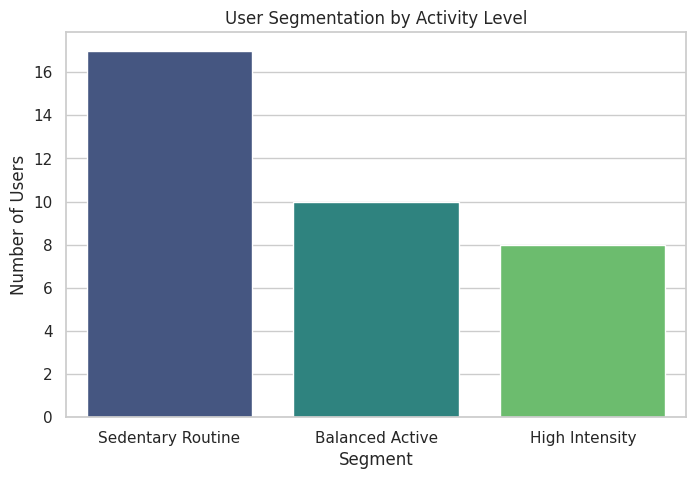

In [42]:
# 1. User Segments
plt.figure(figsize=(8, 5))
sns.barplot(
    x=user_profile['segment'].value_counts().index, 
    y=user_profile['segment'].value_counts().values, 
    palette='viridis',
)

plt.title('User Segmentation by Activity Level')
plt.ylabel('Number of Users')
plt.xlabel('Segment')
plt.show()

**Insights**

This distribution indicates that Bellabeat’s primary consumer is likely an individual managing a desk-bound lifestyle, such as a student or office worker, rather than a high-performance athlete. The data suggests that for nearly half of the users, daily routines are dominated by long periods of stagnation, which presents a clear target demographic for intervention-based wellness features.

## 5.2. Impact of Daily Step Count on Total Sleep Duration

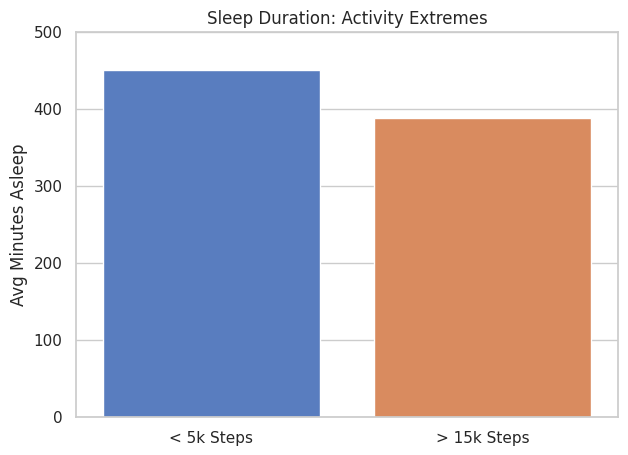

In [43]:
groups = ['< 5k Steps', '> 15k Steps']
sleep_means = [low_steps.mean(), high_steps.mean()]
plt.figure(figsize=(7, 5))
sns.barplot(x=groups, y=sleep_means, palette='muted')
plt.title('Sleep Duration: Activity Extremes')
plt.ylabel('Avg Minutes Asleep')
plt.ylim(0, 500)
plt.show()

**Insights**

The results indicate that high physical activity levels do not correlate with longer sleep duration for this group; in fact, the inverse is observed. This suggests a "time-trade-off" lifestyle where highly active users may be sacrificing rest to maintain their step counts or are balancing high-pressure schedules that prioritise physical tasks over recovery.

## 5.3. Cumulative Hourly Calorie Burn Throughout the Day

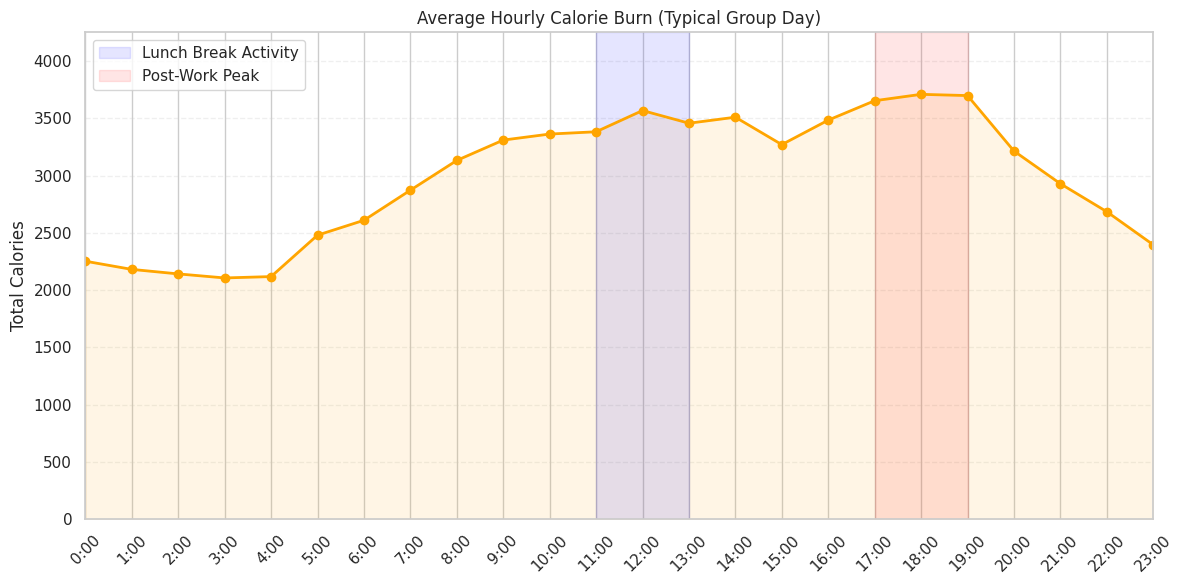

In [44]:
daily_hourly_sum = df_hourly.groupby('activity_hour')['calories'].sum().reset_index()
hourly_typical = daily_hourly_sum.groupby(daily_hourly_sum['activity_hour'].dt.hour)['calories'].mean()
x_values = hourly_typical.index
y_values = hourly_typical.values
labels = [f"{h}:00" for h in x_values]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x_values, y_values, marker='o', color='orange', linewidth=2)
plt.fill_between(x_values, y_values, color='orange', alpha=0.1)
plt.xlim(0, 23)
plt.axvspan(11, 13, color='blue', alpha=0.1, label='Lunch Break Activity')
plt.axvspan(17, 19, color='red', alpha=0.1, label='Post-Work Peak')
plt.xticks(x_values, labels, rotation=45)

# Formatting
plt.ylim(0, 4250)
plt.title('Average Hourly Calorie Burn (Typical Group Day)')
plt.ylabel('Total Calories')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**Insights**

The user base exhibits a logical progression of physical activity tied to a standard daily schedule. The first major surge occurs during the **11:00 AM to 1:00 PM** window, which likely reflects movement during lunch breaks or midday errands. This is followed by a more intensive **120-minute surge between 5:00 PM and 7:00 PM**. This evening spike, peaking at 6:00 PM, aligns with the transition from work to home, likely capturing calories burned during the evening commute and the start of post-work exercise routines.

## 5.4 User Data Logging Consistency and Weekly Tracking Gaps

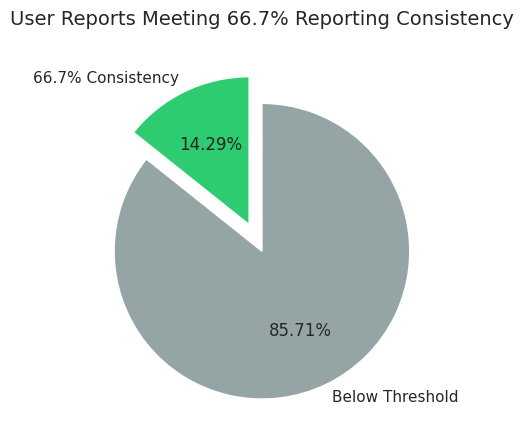

In [45]:
# 1. Prepare data using the variables defined in the previous cell
data = [consistent_users_count, total_users - consistent_users_count]
labels = [f'{threshold:.1%} Consistency', 'Below Threshold']

# 2. Plotting the results
explode_val = (0.2, 0) if consistent_users_count > 0 else (0, 0)

plt.pie(data, labels=labels, autopct='%1.2f%%', startangle=90, 
        colors=['#2ecc71', '#95a5a6'], explode=explode_val)

plt.title(f'User Reports Meeting {threshold:.1%} Reporting Consistency', pad=30, fontsize=14)

plt.show()

**Insights**

The low consistency rate highlights a significant challenge in long-term user retention and daily device engagement. The fact that tracking habits specifically break down on **Fridays** suggests that users are less likely to maintain their wellness routines as they transition out of structured work-week schedules and into the weekend. This indicates a loss of data precisely when user lifestyles become more variable and less predictable.

## 5.5. Comparative Analysis of Step Averages: Weekdays vs. Weekends

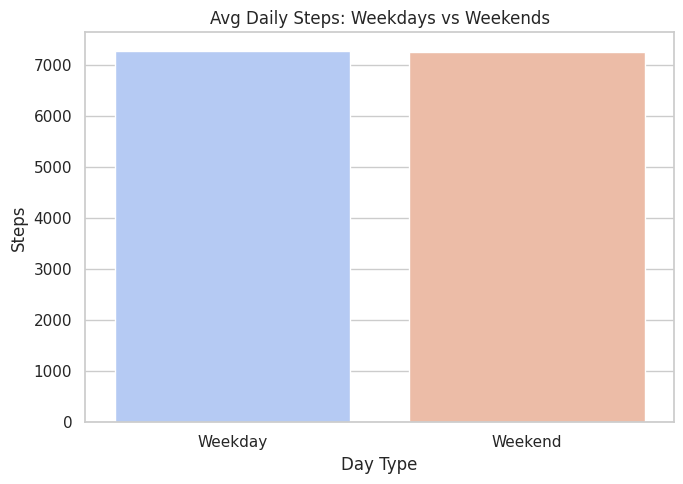

In [46]:
plt.figure(figsize=(7, 5))
sns.barplot(x=day_type_avg.index, y=day_type_avg.values, palette='coolwarm')

plt.title('Avg Daily Steps: Weekdays vs Weekends')
plt.xlabel('Day Type')
plt.ylabel('Steps')
plt.tight_layout()
plt.show()

**Insights**

The data reveals that activity levels are remarkably consistent across the entire week, with a negligible drop of less than **1%** on weekends. This suggests that Bellabeat users are **"Routine-Reliant,"** maintaining a steady level of movement regardless of whether they are following a structured work schedule or enjoying personal time. Their physical activity appears to be a stable habit rather than one dictated by a specific environment, such as a commute or office setting.

# **Step 6:** $Act$
<hr style="height:5px; background-color:black;">

<span style="font-size:24px">**Based on the findings above, I recommend the following for the **Time** watch:**</span>


**1. Break the Cycle**

The marketing team should pivot the "Time" watch's messaging away from high-endurance performance and toward **"breaking the cycle"** of daily stagnation. Rather than focusing on extreme fitness metrics, campaigns should highlight features like hourly movement reminders, "stagnation alerts," and milestones for consistent, low-intensity movement that resonate with the sedentary majority.

**2. Holistic Wellness Integration**

Marketing should position Bellabeat as a **holistic recovery partner** rather than just a step tracker. By emphasising that high activity requires proportional rest, the brand can promote a balanced health narrative. Recommendations include introducing "Recovery Mode" features that encourage highly active users to prioritise sleep duration, ensuring that their physical efforts are supported by adequate nightly rest.

**3. Routine-Integrated Engagement**

The marketing team should synchronise app engagement with these natural daily transitions. To capitalise on the 11:00 AM surge, the app can send prompts for "midday active breaks" or lunch-time step goals. For the primary **5:00 PM to 7:00 PM** window, messaging should shift toward "closing the ring" or maximising the commute through active travel, ensuring Bellabeat becomes a functional tool during the most active phases of the user’s day.


**4. Weekend Retention Pivot**

The marketing and product teams should focus on a **"Weekend Continuity" retention campaign**. Since engagement drops as the work-week ends, the app should deploy specialised Friday afternoon "Weekend Goal" notifications or social challenges to maintain momentum through the gap days. By gamifying weekend tracking or offering rewards for completing a full 7-day data set, Bellabeat can mitigate the substantial loss of wellness data that currently occurs during the Friday transition.

**5. Lifestyle Consistency Campaign**

The marketing team should capitalise on this high level of baseline consistency by launching a **"Life in Motion"** campaign. Since users do not significantly "drop off" during the weekend, the brand should reinforce this behavior by promoting the "Time" watch as a seamless companion for both professional and leisure environments. Recommendations include highlighting the device's aesthetic versatility and its ability to track consistent progress across different lifestyle contexts without the need for manual mode adjustments.